
# Blog Text Classification & Sentiment Analysis

This notebook implements a complete **text classification and sentiment analysis pipeline**.

### Project Flow
1. Load raw blog dataset  
2. Preprocess text data  
3. Feature extraction using TF-IDF  
4. Train Naive Bayes classifier  
5. Evaluate model performance  
6. Perform sentiment analysis  

All outputs (models, reports, results) are saved automatically.


## 1. Install & Import Required Libraries

In [1]:

# Install required libraries (run once)
# !pip install nltk textblob scikit-learn matplotlib

import os
import re
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay


## 2. Create Required Folders

In [2]:

folders = [
    "data/raw",
    "data/processed",
    "models",
    "reports",
    "outputs"
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("All required folders are ready.")


All required folders are ready.


## 3. Load Raw Dataset

In [3]:

data_path = "data/raw/blogs_categories.csv"

if not os.path.exists(data_path):
    raise FileNotFoundError("Place blogs_categories.csv inside data/raw/")

df = pd.read_csv(data_path)
print(df.shape)
df.head()


(2000, 2)


,Data,Labels
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,alt.atheism
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,alt.atheism
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism
4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,alt.atheism


## 4. Text Preprocessing

In [4]:

stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)

df = df.dropna(subset=["Data"])
df["Cleaned_Text"] = df["Data"].apply(clean_text)

df.to_csv("data/processed/cleaned_blogs.csv", index=False)
df.head()


,Data,Labels,Cleaned_Text
0,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism,path cantaloupesrvcscmuedumagnesiumclubcccmued...
1,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,alt.atheism,newsgroups altatheism path cantaloupesrvcscmue...
2,Path: cantaloupe.srv.cs.cmu.edu!das-news.harva...,alt.atheism,path cantaloupesrvcscmuedudasnewsharvardedunoc...
3,Path: cantaloupe.srv.cs.cmu.edu!magnesium.club...,alt.atheism,path cantaloupesrvcscmuedumagnesiumclubcccmued...
4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:53...,alt.atheism,xref cantaloupesrvcscmuedu altatheism talkreli...


## 5. Feature Engineering (TF-IDF)

In [5]:

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["Cleaned_Text"])
y = df["Labels"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("TF-IDF Shape:", X.shape)


TF-IDF Shape: (2000, 5000)


## 6. Train Naive Bayes Model

In [6]:

model = MultinomialNB()
model.fit(X_train, y_train)

with open("models/naive_bayes_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("models/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print("Model and vectorizer saved.")


Model and vectorizer saved.


## 7. Model Evaluation

Accuracy : 0.855
Precision: 0.8625528369642652
Recall   : 0.855
F1-score : 0.8554325343839753


<Figure size 800x600 with 0 Axes>

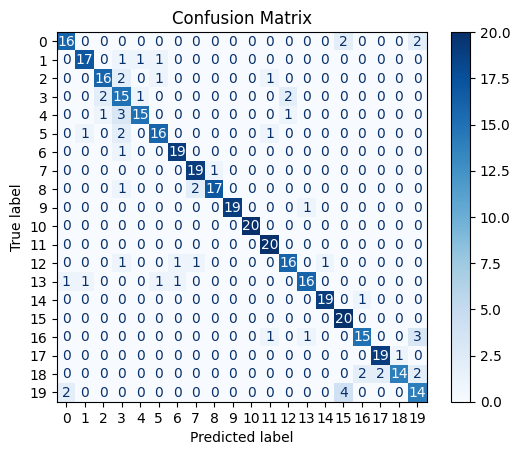

In [7]:

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="weighted"
)

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(8,6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.savefig("reports/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()


## 8. Sentiment Analysis

In [8]:

def get_sentiment_label(p):
    if p > 0:
        return "Positive"
    elif p < 0:
        return "Negative"
    return "Neutral"

df["Polarity"] = df["Cleaned_Text"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["Sentiment"] = df["Polarity"].apply(get_sentiment_label)

df.to_csv("outputs/sentiment_results.csv", index=False)

df[["Polarity", "Sentiment"]].head()


,Polarity,Sentiment
0,0.058664,Positive
1,-0.002480,Negative
2,0.025719,Positive
3,0.059244,Positive
4,0.149802,Positive


## 9. Sentiment Summary

In [9]:

summary = df["Sentiment"].value_counts()

with open("reports/sentiment_summary.txt", "w") as f:
    f.write("SENTIMENT SUMMARY\n")
    f.write("-----------------\n")
    for k, v in summary.items():
        f.write(f"{k}: {v}\n")

summary


Sentiment
Positive    1452
Negative     545
Neutral        3
Name: count, dtype: int64